In [18]:
import pandas as pd
import numpy as np
import os
import datetime
import pickle as pkl
import sys
sys.path.append(r'/home/datamake8/hqth_sec_strategy')
sys.path.append(r'/home/datamake8/common_code')
from sec_support import *
from tonglian_config import *

ohlc_path = r'/home/datamake8/basic_data/tonglian_data2/ohlc_fea'
support_path = r'/home/datamake8/data0/trade_support'

TURNOVER_RATE = pd.read_feather(os.path.join(ohlc_path, 'TURNOVER_RATE.fea'))
TURNOVER_VALUE = pd.read_feather(os.path.join(ohlc_path, 'TURNOVER_VALUE.fea'))
MARKET_VALUE = pd.read_feather(os.path.join(ohlc_path, 'NEG_MARKET_VALUE.fea'))

TURNOVER_VALUE = TURNOVER_VALUE.set_index('TRADE_DATE')
TURNOVER_VALUE.index = pd.to_datetime(TURNOVER_VALUE.index).strftime('%Y%m%d')
TURNOVER_VALUE = TURNOVER_VALUE.rolling(5).mean().shift(1)
MARKET_VALUE = MARKET_VALUE.set_index('TRADE_DATE')
MARKET_VALUE.index = pd.to_datetime(MARKET_VALUE.index).strftime('%Y%m%d')
MARKET_VALUE = MARKET_VALUE.rolling(5).mean().shift(1)

class params:
    citic_share_limit = 0.002
    cmvg_share_limit = 0.002
    turnover_limit = 0.4
    hold_limit_ratio_long = 0.01
    hold_limit_ratio_short = 0.01
    t0_score_ratio = 0.15
    assume_rq_time = 5  # 假设每只股票最多能融5天

In [19]:
import cvxpy as cp
def get_target_stock_ratio(date, pre_amt_dict):
    pre_date = date_list_all[date_list_all.index(date) - 1]
    pre_amt_se = pd.Series(pre_amt_dict)

    # 读取trade_support信息
    td_support = pd.read_csv(os.path.join(support_path, f'{pre_date}_trade_support.csv'),index_col=0)
    valid_code = [x for x in td_support.index if x//10000 in [0,30,60,68]]
    td_support = td_support.loc[valid_code]
    stock_list = td_support.index.tolist()
    td_black = pd.read_csv(r'/home/datamake8/ITdev/sample_data/black_list/%s_black_list.csv'%pre_date,index_col=0)
    td_black = td_black[td_black['black']==True].index.tolist()
    td_black = [int(x) for x in td_black]
    stock_list = [x for x in stock_list if x not in td_black]
    # 根据昨日股票名单求并集
    pre_stock_list = pre_amt_se.index.tolist()
    stock_list = sorted(list(set(stock_list) | set(pre_stock_list)))
    pre_amt_se = pre_amt_se.reindex(stock_list).fillna(0)
    pre_amt_hold = pre_amt_se[pre_amt_se>0].reindex(stock_list).fillna(0)
    pre_amt_rq = pre_amt_se[pre_amt_se<0].reindex(stock_list).fillna(0)

    #筛选融券名单
    period_date_list = date_list_all[date_list_all.index(date)-params.assume_rq_time:date_list_all.index(date)]
    total_rq_stock = []
    for dt in period_date_list:
        daily_rq_stock_df = pd.read_pickle(r'/home/datamake8/data0/海通券单_新/%s.pkl'%dt)
        daily_rq_stock_df = daily_rq_stock_df[~pd.isnull(daily_rq_stock_df['code'])].copy()
        daily_rq_stock_df['code'] = daily_rq_stock_df['code'].astype(int)
        daily_rq_stock = sorted(daily_rq_stock_df['code'].drop_duplicates().tolist())
        daily_rq_stock = [x for x in daily_rq_stock if x in stock_list]
        total_rq_stock.extend(daily_rq_stock)
    total_rq_stock = sorted(list(set(total_rq_stock)))

    cmvg_mtx = pd.get_dummies(td_support.reindex(index=stock_list)['cmv_group']).T.astype(int).fillna(0)
    cmvg_mtx = cmvg_mtx.values
    citic_mtx = pd.get_dummies(td_support.reindex(index=stock_list)['citic1_code']).T.astype(int).fillna(0)
    citic_mtx = citic_mtx.values

    #根据过去5日的股票打分情况筛选股票
    period_date_list = date_list_all[date_list_all.index(date)-5-1:date_list_all.index(date)-1]
    score_dict = {}
    for dt in period_date_list:
        if dt <= '20230630': score_path = r'/home/datamake8/datamake94/second_score/dcn_bert_multiperiod_5m_final_0323_wccc_all'
        # else: score_path = r'/home/datamake8/datamake94/second_score/dcn_bert_multiperiod_5m_final_0323_wccc_all_sota2'
        else: score_path = r'/home/datamake8/datamake94/second_score/dcn_bert_multiperiod_5m_final_0529_factor1057_wccc_all_sota2_final'
        score_data = pd.read_feather(os.path.join(score_path, f'{dt}.fea')).set_index('second')
        # score_data = get_alpha_dict(stock_list,dt,score_ratio_1m=0.2,score_ratio_15s=0.2, score_ratio_5m=0.6)['sec_300s']
        score_data.columns = score_data.columns.astype(int)
        score_std = score_data.std(axis=0)
        score_range = score_data.max(axis=0) - score_data.min(axis=0)
        score_dict[dt] = score_std.rank(pct=True) + score_range.rank(pct=True)
    score_mean = pd.DataFrame(score_dict).mean(axis=1).reindex(stock_list).fillna(0)
    score_select_stock_long = score_mean[score_mean.rank(pct=True)>(1-params.t0_score_ratio)].index.tolist()
    score_select_stock_short = score_mean[score_mean.rank(pct=True)>(1-params.t0_score_ratio)].index.tolist()

    #根据过去1日的长周期股票打分情况筛选股票
    period_date_list = date_list_all[date_list_all.index(date)-1-1:date_list_all.index(date)-1]
    score_dict_short = {}
    model_ratio = {'norm':1}
    score_path_dict = {
        'norm':r'/home/datamake8/database_00/min_score_period30/min_score_period1d_allstock_adj_transformer_final_select3_doublenorm_ver2_0618_wpcc_pwtrain',
        'tabnet':r'/home/datamake8/database_00/min_score_period30/min_score_period1d_allstock_adj_tabnet_final_select3_doublenorm_ver2_0618_wpcc_pwtrain',
    }
    for dt in period_date_list:
        score_model_list = []
        for model_tag in list(model_ratio.keys()):
            score_data = pd.read_feather(os.path.join(score_path_dict[model_tag], f'{dt}.fea')).set_index('index').loc[1440:]
            # score_data = get_alpha_dict(stock_list,dt,score_ratio_1m=0.2,score_ratio_15s=0.2, score_ratio_5m=0.6)['sec_300s']
            score_data.columns = score_data.columns.astype(int)
            # score_model_list.append(score_data.mean(axis=0).rank(pct=True).reindex(stock_list).fillna(0.5) * model_ratio[model_tag])
            score_data = score_data.mean(axis=0)#.rank(pct=True)
            score_model_list.append(score_data * model_ratio[model_tag])

        score_dict_short[dt] = sum(score_model_list)
    score_mean_short = pd.DataFrame(score_dict_short).mean(axis=1).reindex(stock_list).fillna(0)

    # 开始组合优化，多空+T0双打分优化

    def make_parameter(param_s,fill=0):
        return param_s.reindex(stock_list).replace([np.inf,-np.inf],np.nan).fillna(fill).values #cp.Parameter(
    
    n = len(stock_list)
    for i in range(30):
        cons = []
        zeros = np.repeat(0, n).T
        ones = np.repeat(1, n).T
        allhold_amt = cp.Variable(n)
        prehold_amt = make_parameter(pre_amt_se)
        citic_share_limit, cmvg_share_limit = (i+1)*params.citic_share_limit, (i+1)*params.cmvg_share_limit

        # 市值约束
        all_cmvg = cmvg_mtx @ allhold_amt
        mv_value = MARKET_VALUE.loc[date_list[date_list.index(date)-2]]
        mv_value.index = [int(x) for x in mv_value.index]
        mv_value = np.log(mv_value.reindex(index=stock_list).fillna(mv_value.mean()))
        # mv_value_mean = mv_value.mean()
        mv_value_std = mv_value.std()
        cons.extend([all_cmvg + cmvg_share_limit >= 0,
                     all_cmvg - cmvg_share_limit <= 0,
                     mv_value.values @ allhold_amt >= -0.15*mv_value_std,
                     mv_value.values @ allhold_amt <= 0.15*mv_value_std,
                     ])
        #行业约束
        all_citic = citic_mtx @ allhold_amt
        cons.extend([all_citic + citic_share_limit >= 0,
                     all_citic - citic_share_limit <= 0,
                     ])

        #个股持仓约束
        hold_limit_up = pd.Series({stock: params.hold_limit_ratio_long if stock in score_select_stock_long and stock not in td_black else 0 for stock in stock_list}).values
        hold_limit_down = pd.Series({stock: -params.hold_limit_ratio_short if stock in total_rq_stock and stock not in td_black and stock in score_select_stock_short else 0 for stock in stock_list}).values
        today_new_rq_limit = pd.Series({stock: params.hold_limit_ratio_short if stock in daily_rq_stock and stock not in td_black and stock in score_select_stock_short else 0 for stock in stock_list}).values
        cons.extend([
            allhold_amt >= hold_limit_down,
            allhold_amt <= hold_limit_up,
            cp.neg(allhold_amt) - cp.neg(prehold_amt) <= today_new_rq_limit,
        ])

        # #换手率约束，只约束卖出
        # if pre_amt_se[pre_amt_se>0].sum() > 0.95:
        #     cons.extend([
        #         0.5*(cp.sum(cp.abs(allhold_amt - prehold_amt)) - cp.sum(allhold_amt - prehold_amt)) <= params.turnover_limit,
        #     ])

        #其他约束
        cons.extend([
            cp.sum(allhold_amt) <= 0.005,
            cp.sum(allhold_amt) >= -0.005,
            cp.sum(cp.pos(allhold_amt)) <= 1,
        ])

        # 定义问题，仓位打分差最小化
        obj = cp.Maximize(score_mean_short.values @ allhold_amt)
        # obj = cp.Maximize(score_mean.values @ pos_amt)
        # obj = cp.Maximize(score_mean.values @ allhold_amt)

        prob = cp.Problem(obj, cons)
        # 求解
        ans = prob.solve(solver='SCIPY',verbose=False)
        # output = pd.Series(pre_amt_se + buy_amt.value - sell_amt.value,index=stock_list)
        if allhold_amt.value is not None:
            break

        if (allhold_amt.value is None) and i==29:
            print(date, '组合优化始终无解')
            return date, {}

    output = pd.Series(allhold_amt.value,index=stock_list)
    print(i,output[output>0].sum(),output[output<0].sum())
    output = output[output!=0].copy()

    return date, output.to_dict()

In [20]:
valid_stock_dict = {}
pre_amt_dict = {}
# pre_amt_dict = pkl.load(open(r'/home/datamake8/data0/底仓T0股票/stk_dict_update20240701_0/20240325.pkl','rb'))
date_list_all = get_datelist_all()
date_list = get_datelist('20230103','20240430')
# dl = DataLoaderX(SDataset(date_list[6:],get_target_stock_ratio),collate_fn=lambda x:x[0],batch_size=1,num_workers=0,shuffle=False,drop_last=False)
path = r'/home/datamake8/data0/底仓T0股票/stk_dict_update20240703_5'
os.makedirs(path,exist_ok=True)
params_dict = {
    'citic_share_limit':params.citic_share_limit,
    'cmvg_share_limit':params.cmvg_share_limit,
    'turnover_limit':params.turnover_limit,
    'hold_limit_ratio_long':params.hold_limit_ratio_long,
    'hold_limit_ratio_short':params.hold_limit_ratio_short,
    't0_score_ratio':params.t0_score_ratio,
}
with open(os.path.join(path, 'params.pkl'),'wb') as f:
    pkl.dump(params_dict,f)
for date in tqdm(date_list[6:]):
    date,valid_stock_list = get_target_stock_ratio(date, pre_amt_dict)
    valid_stock_dict[date] = valid_stock_list
    if len(valid_stock_list)!=0: pre_amt_dict = valid_stock_list
    with open(os.path.join(path, date+'.pkl'),'wb') as f:
        pkl.dump(valid_stock_list,f)

  0%|                                                                         | 0/314 [00:00<?, ?it/s]

  0%|▏                                                                | 1/314 [00:03<17:30,  3.36s/it]

0 0.9999999999999991 -1.0005335365450676


  1%|▍                                                                | 2/314 [00:06<17:29,  3.36s/it]

0 0.9999999999999991 -1.003371149061759


  1%|▌                                                                | 3/314 [00:09<17:10,  3.31s/it]

0 0.9999999999999991 -1.0039999999999998


  1%|▊                                                                | 4/314 [00:13<16:39,  3.22s/it]

0 0.9999999999999991 -0.998989349408957


  2%|█                                                                | 5/314 [00:16<16:17,  3.16s/it]

0 0.9999999999999993 -1.0030718642603798


  2%|█▏                                                               | 6/314 [00:19<16:14,  3.16s/it]

0 0.9999999999999992 -1.0038196186880506


  2%|█▍                                                               | 7/314 [00:22<16:23,  3.20s/it]

0 0.9999999999999991 -1.004999999999999


  3%|█▋                                                               | 8/314 [00:26<16:45,  3.29s/it]

0 0.9999999999999992 -1.00165329260702


  3%|█▊                                                               | 9/314 [00:29<17:24,  3.43s/it]

0 0.9999999999999991 -1.004999999999999


  3%|██                                                              | 10/314 [00:33<17:41,  3.49s/it]

0 0.9999999999999991 -1.000325514470797


  4%|██▏                                                             | 11/314 [00:37<17:58,  3.56s/it]

0 0.9999999999999991 -0.9972245944052949


  4%|██▍                                                             | 12/314 [00:40<18:11,  3.61s/it]

0 0.9999999999999991 -1.0038286289640865


  4%|██▋                                                             | 13/314 [00:44<18:25,  3.67s/it]

0 0.9999999999999992 -0.997999999999999


  4%|██▊                                                             | 14/314 [00:48<18:27,  3.69s/it]

0 0.9999999999999991 -1.0049259142010625


  5%|███                                                             | 15/314 [00:51<17:57,  3.60s/it]

0 0.9999999999999991 -1.0022670264334728


  5%|███▎                                                            | 16/314 [00:55<17:49,  3.59s/it]

0 1.0 -1.005


  5%|███▍                                                            | 17/314 [00:59<18:03,  3.65s/it]

0 0.9999999999999991 -1.004188334530348


  6%|███▋                                                            | 18/314 [01:02<17:41,  3.59s/it]

0 0.9999999999999991 -1.004999999999999


  6%|███▊                                                            | 19/314 [01:06<17:27,  3.55s/it]

0 0.9999999999999991 -1.0045515291654041


  6%|████                                                            | 20/314 [01:09<17:11,  3.51s/it]

0 0.9999999999999991 -1.003988853595208


  7%|████▎                                                           | 21/314 [01:12<17:09,  3.51s/it]

0 0.9999999999999991 -1.004999999999999


  7%|████▍                                                           | 22/314 [01:16<16:39,  3.42s/it]

0 0.999999999999999 -1.0049999999999994


  7%|████▋                                                           | 23/314 [01:19<16:59,  3.50s/it]

0 0.9999999999999992 -1.0005670255004577


  8%|████▉                                                           | 24/314 [01:23<16:25,  3.40s/it]

0 0.9999999999999992 -1.004999999999999


  8%|█████                                                           | 25/314 [01:26<16:12,  3.37s/it]

0 0.9999999999999991 -1.0026051044868345


  8%|█████▎                                                          | 26/314 [01:29<16:18,  3.40s/it]

0 0.9999999999999991 -1.0033107223330073


  9%|█████▌                                                          | 27/314 [01:33<16:03,  3.36s/it]

0 0.9999999999999991 -1.003052877787054


  9%|█████▋                                                          | 28/314 [01:36<16:00,  3.36s/it]

0 0.9999999999999992 -1.004509924245655


  9%|█████▉                                                          | 29/314 [01:39<15:52,  3.34s/it]

0 0.9999999999999991 -1.0029283392954818


 10%|██████                                                          | 30/314 [01:43<15:53,  3.36s/it]

0 0.9999999999999991 -1.0009659047534976


 10%|██████▎                                                         | 31/314 [01:46<16:05,  3.41s/it]

0 0.9999999999999991 -1.004136877404425


 10%|██████▌                                                         | 32/314 [01:49<15:41,  3.34s/it]

0 0.9999999999999992 -0.9989240188144686


 11%|██████▋                                                         | 33/314 [01:52<15:20,  3.28s/it]

0 0.9999999999999991 -0.9996838145432869


 11%|██████▉                                                         | 34/314 [01:56<15:01,  3.22s/it]

0 0.9999999999999991 -1.004999999999999


 11%|███████▏                                                        | 35/314 [01:59<14:47,  3.18s/it]

0 0.9999999999999991 -1.0035994153515326


 11%|███████▎                                                        | 36/314 [02:02<14:33,  3.14s/it]

0 0.9999999999999992 -1.0016935300697214


 12%|███████▌                                                        | 37/314 [02:05<14:23,  3.12s/it]

0 0.9999999999999991 -1.004999999999999


 12%|███████▋                                                        | 38/314 [02:08<14:16,  3.10s/it]

0 0.9999999999999992 -1.004999999999999


 12%|███████▉                                                        | 39/314 [02:11<14:16,  3.11s/it]

0 0.9999999999999991 -1.004999999999999


 13%|████████▏                                                       | 40/314 [02:14<14:15,  3.12s/it]

0 0.9999999999999992 -1.0049999999999992


 13%|████████▎                                                       | 41/314 [02:17<14:09,  3.11s/it]

0 0.9999999999999992 -1.0049999999999992


 13%|████████▌                                                       | 42/314 [02:20<14:06,  3.11s/it]

0 0.9999999999999996 -1.004999999999999


 14%|████████▊                                                       | 43/314 [02:23<14:04,  3.12s/it]

0 0.9999999999999991 -1.004909648294379


 14%|████████▉                                                       | 44/314 [02:27<14:01,  3.12s/it]

0 0.9999999999999992 -1.004999999999999


 14%|█████████▏                                                      | 45/314 [02:30<13:59,  3.12s/it]

0 0.9999999999999991 -1.0014164264736722


 15%|█████████▍                                                      | 46/314 [02:33<13:52,  3.11s/it]

0 0.9999999999999991 -1.004999999999999


 15%|█████████▌                                                      | 47/314 [02:36<13:45,  3.09s/it]

0 0.9999999999999991 -1.0049999999999992


 15%|█████████▊                                                      | 48/314 [02:39<13:40,  3.08s/it]

0 0.9999999999999991 -1.004458527204961


 16%|█████████▉                                                      | 49/314 [02:42<13:35,  3.08s/it]

0 0.9999999999999991 -1.005


 16%|██████████▏                                                     | 50/314 [02:45<13:30,  3.07s/it]

0 0.9999999999999991 -1.0049999999999988


 16%|██████████▍                                                     | 51/314 [02:48<13:28,  3.07s/it]

0 0.9999999999999992 -1.0006112279084773


 17%|██████████▌                                                     | 52/314 [02:51<13:28,  3.09s/it]

0 0.9999999999999991 -1.0045309454168696


 17%|██████████▊                                                     | 53/314 [02:54<13:33,  3.12s/it]

0 0.9999999999999992 -1.004999999999999


 17%|███████████                                                     | 54/314 [02:58<13:32,  3.13s/it]

0 0.9999999999999991 -1.004999999999999


 18%|███████████▏                                                    | 55/314 [03:01<13:33,  3.14s/it]

0 0.9999999999999992 -0.9979999999999992


 18%|███████████▍                                                    | 56/314 [03:04<13:32,  3.15s/it]

0 0.9999999999999992 -0.9979090826241653


 18%|███████████▌                                                    | 57/314 [03:07<13:31,  3.16s/it]

0 0.9999999999999991 -1.0025300582977568


 18%|███████████▊                                                    | 58/314 [03:10<13:29,  3.16s/it]

0 0.9999999999999991 -1.0014166125846318


 19%|████████████                                                    | 59/314 [03:13<13:26,  3.16s/it]

0 0.9999999999999998 -1.0005698122154456


 19%|████████████▏                                                   | 60/314 [03:17<13:24,  3.17s/it]

0 0.9999999999999992 -1.004999999999999


 19%|████████████▍                                                   | 61/314 [03:20<13:23,  3.18s/it]

0 0.9999999999999991 -1.0047605886513729


 20%|████████████▋                                                   | 62/314 [03:23<13:19,  3.17s/it]

0 0.9999999999999991 -1.004999999999999


 20%|████████████▊                                                   | 63/314 [03:26<13:15,  3.17s/it]

0 0.999999999999999 -1.0043036622310277


 20%|█████████████                                                   | 64/314 [03:29<13:12,  3.17s/it]

0 0.9999999999999991 -1.0042662326039613


 21%|█████████████▏                                                  | 65/314 [03:32<13:08,  3.17s/it]

0 0.9999999999999991 -1.004999999999999


 21%|█████████████▍                                                  | 66/314 [03:36<13:05,  3.17s/it]

0 0.9999999999999991 -1.004999999999999


 21%|█████████████▋                                                  | 67/314 [03:39<13:04,  3.18s/it]

0 0.9999999999999991 -1.0039999999999982


 22%|█████████████▊                                                  | 68/314 [03:42<13:02,  3.18s/it]

0 0.9999999999999992 -1.0034321924005898


 22%|██████████████                                                  | 69/314 [03:45<12:57,  3.17s/it]

0 0.9999999999999992 -1.004999999999999


 22%|██████████████▎                                                 | 70/314 [03:48<12:53,  3.17s/it]

0 0.9999999999999992 -1.0045995493560258


 23%|██████████████▍                                                 | 71/314 [03:51<12:45,  3.15s/it]

0 0.9999999999999991 -1.0006206767840182


 23%|██████████████▋                                                 | 72/314 [03:55<12:41,  3.15s/it]

0 0.9999999999999991 -1.0042885705454663


 23%|██████████████▉                                                 | 73/314 [03:58<12:37,  3.14s/it]

0 0.9999999999999991 -1.004999999999999


 24%|███████████████                                                 | 74/314 [04:01<12:34,  3.15s/it]

0 0.9999999999999991 -0.9984998394220063


 24%|███████████████▎                                                | 75/314 [04:04<12:35,  3.16s/it]

0 0.9999999999999992 -0.9991066609987315


 24%|███████████████▍                                                | 76/314 [04:07<12:32,  3.16s/it]

0 0.9999999999999991 -1.0049463351376604


 25%|███████████████▋                                                | 77/314 [04:10<12:31,  3.17s/it]

0 0.9999999999999991 -0.9979999999999991


 25%|███████████████▉                                                | 78/314 [04:13<12:20,  3.14s/it]

0 0.9999999999999991 -1.0035998824152763


 25%|████████████████                                                | 79/314 [04:16<12:09,  3.10s/it]

0 0.9999999999999992 -0.9972881184622338


 25%|████████████████▎                                               | 80/314 [04:20<12:02,  3.09s/it]

0 0.9999999999999991 -0.9980364049176413


 26%|████████████████▌                                               | 81/314 [04:23<11:58,  3.08s/it]

0 0.9999999999999992 -1.0026180926096182


 26%|████████████████▋                                               | 82/314 [04:26<11:57,  3.09s/it]

0 0.9999999999999991 -1.0010085330446499


 26%|████████████████▉                                               | 83/314 [04:29<11:56,  3.10s/it]

0 0.9999999999999992 -1.004999999999999


 27%|█████████████████                                               | 84/314 [04:32<11:53,  3.10s/it]

0 1.0 -0.9996123125973913


 27%|█████████████████▎                                              | 85/314 [04:35<11:44,  3.08s/it]

0 0.999999999999999 -0.9996622564299252


 27%|█████████████████▌                                              | 86/314 [04:38<11:38,  3.06s/it]

0 0.9999999999999991 -0.9965737025486552


 28%|█████████████████▋                                              | 87/314 [04:41<11:47,  3.12s/it]

0 0.9999999999999991 -1.004584349976033


 28%|█████████████████▉                                              | 88/314 [04:44<11:36,  3.08s/it]

0 0.9999999999999991 -1.0019999999999991


 28%|██████████████████▏                                             | 89/314 [04:47<11:30,  3.07s/it]

0 0.9999999999999999 -0.9979999999999998


 29%|██████████████████▎                                             | 90/314 [04:50<11:29,  3.08s/it]

0 0.9999999999999992 -1.0019999999999991


 29%|██████████████████▌                                             | 91/314 [04:53<11:29,  3.09s/it]

0 0.9999999999999991 -0.9999999999999991


 29%|██████████████████▊                                             | 92/314 [04:57<11:25,  3.09s/it]

0 0.9999999999999991 -1.0039999999999991


 30%|██████████████████▉                                             | 93/314 [05:00<11:21,  3.08s/it]

0 0.9999999999999991 -1.0021251275391283


 30%|███████████████████▏                                            | 94/314 [05:03<11:18,  3.08s/it]

0 0.9999999999999991 -1.0008661929298317


 30%|███████████████████▎                                            | 95/314 [05:06<11:20,  3.11s/it]

0 0.9999999999999991 -0.9999999999999991


 31%|███████████████████▌                                            | 96/314 [05:09<11:26,  3.15s/it]

0 0.9999999999999991 -1.0008106284434761


 31%|███████████████████▊                                            | 97/314 [05:12<11:34,  3.20s/it]

0 0.9999999999999992 -0.9987943615956179


 31%|███████████████████▉                                            | 98/314 [05:16<11:39,  3.24s/it]

0 0.9999999999999991 -1.001999999999999


 32%|████████████████████▏                                           | 99/314 [05:19<11:32,  3.22s/it]

0 0.9999999999999991 -1.0009999999999994


 32%|████████████████████                                           | 100/314 [05:22<11:24,  3.20s/it]

0 0.9999999999999991 -1.001999999999999


 32%|████████████████████▎                                          | 101/314 [05:25<11:24,  3.21s/it]

0 0.9999999999999991 -0.9979999999999999


 32%|████████████████████▍                                          | 102/314 [05:29<11:30,  3.26s/it]

0 0.9999999999999991 -0.9983706078203032


 33%|████████████████████▋                                          | 103/314 [05:32<11:20,  3.22s/it]

0 0.956 -0.958


 33%|████████████████████▊                                          | 104/314 [05:35<11:13,  3.21s/it]

0 0.9999999999999992 -0.9956373087981395


 33%|█████████████████████                                          | 105/314 [05:38<11:04,  3.18s/it]

0 0.9999999999999991 -0.9989679135731524


 34%|█████████████████████▎                                         | 106/314 [05:41<10:55,  3.15s/it]

0 0.9999999999999991 -0.9999566594331084


 34%|█████████████████████▍                                         | 107/314 [05:44<10:44,  3.11s/it]

0 0.9999999999999991 -0.994999999999999


 34%|█████████████████████▋                                         | 108/314 [05:47<10:37,  3.10s/it]

0 0.999999999999999 -0.9999104180012528


 35%|█████████████████████▊                                         | 109/314 [05:50<10:36,  3.11s/it]

0 0.9999999999999991 -0.997999999999999


 35%|██████████████████████                                         | 110/314 [05:54<10:39,  3.13s/it]

0 1.0 -0.9959999999999999


 35%|██████████████████████▎                                        | 111/314 [05:57<10:40,  3.16s/it]

0 0.9999999999999991 -1.0024483868919984


 36%|██████████████████████▍                                        | 112/314 [06:00<10:44,  3.19s/it]

0 0.9999999999999992 -0.994999999999999


 36%|██████████████████████▋                                        | 113/314 [06:03<10:43,  3.20s/it]

0 0.9999999999999991 -1.0039999999999991


 36%|██████████████████████▊                                        | 114/314 [06:07<10:41,  3.21s/it]

0 0.9999999999999991 -1.001877931571559


 37%|███████████████████████                                        | 115/314 [06:10<10:39,  3.21s/it]

0 0.9999999999999991 -0.9995545854572023


 37%|███████████████████████▎                                       | 116/314 [06:13<10:37,  3.22s/it]

0 0.9999999999999991 -0.9982729375847892


 37%|███████████████████████▍                                       | 117/314 [06:16<10:33,  3.21s/it]

0 0.9999999999999991 -1.004999999999999


 38%|███████████████████████▋                                       | 118/314 [06:19<10:32,  3.23s/it]

0 0.9999999999999991 -1.003984878358572


 38%|███████████████████████▉                                       | 119/314 [06:23<10:32,  3.24s/it]

0 0.9999999999999991 -1.0047226056619274


 38%|████████████████████████                                       | 120/314 [06:26<10:33,  3.26s/it]

0 0.9999999999999991 -1.0032904372269649


 39%|████████████████████████▎                                      | 121/314 [06:29<10:32,  3.28s/it]

0 0.9999999999999991 -0.9987279954284325


 39%|████████████████████████▍                                      | 122/314 [06:33<10:26,  3.26s/it]

0 0.9999999999999991 -1.00351647092969


 39%|████████████████████████▋                                      | 123/314 [06:36<10:22,  3.26s/it]

0 0.9999999999999991 -0.9986693364725014


 39%|████████████████████████▉                                      | 124/314 [06:39<10:22,  3.28s/it]

0 0.9999999999999991 -1.0001744240777783


 40%|█████████████████████████                                      | 125/314 [06:42<10:18,  3.27s/it]

0 0.9999999999999992 -0.9984599779329799


 40%|█████████████████████████▎                                     | 126/314 [06:46<10:14,  3.27s/it]

0 0.9999999999999991 -1.0006591891917602


 40%|█████████████████████████▍                                     | 127/314 [06:49<10:08,  3.25s/it]

0 0.9999999999999991 -1.0049999999999992


 41%|█████████████████████████▋                                     | 128/314 [06:52<10:03,  3.24s/it]

0 0.9999999999999991 -0.998


 41%|█████████████████████████▉                                     | 129/314 [06:55<10:06,  3.28s/it]

0 0.9999999999999991 -1.0039999999999987


 41%|██████████████████████████                                     | 130/314 [06:59<10:09,  3.31s/it]

0 0.9999999999999991 -1.004999999999999


 42%|██████████████████████████▎                                    | 131/314 [07:02<10:04,  3.31s/it]

0 0.9999999999999991 -1.0025974676529454


 42%|██████████████████████████▍                                    | 132/314 [07:05<09:59,  3.30s/it]

0 0.9999999999999991 -1.0036019670968739


 42%|██████████████████████████▋                                    | 133/314 [07:09<09:55,  3.29s/it]

0 0.9999999999999991 -1.0019999999999991


 43%|██████████████████████████▉                                    | 134/314 [07:12<09:53,  3.29s/it]

0 0.9999999999999991 -1.0003358240709217


 43%|███████████████████████████                                    | 135/314 [07:15<09:48,  3.29s/it]

0 0.9999999999999991 -1.0037222041188143


 43%|███████████████████████████▎                                   | 136/314 [07:19<09:45,  3.29s/it]

0 0.9999999999999991 -1.0003071866878994


 44%|███████████████████████████▍                                   | 137/314 [07:22<09:43,  3.30s/it]

0 0.9999999999999991 -0.9967310832328655


 44%|███████████████████████████▋                                   | 138/314 [07:25<09:38,  3.29s/it]

0 0.9999999999999992 -1.0035483252226807


 44%|███████████████████████████▉                                   | 139/314 [07:28<09:31,  3.27s/it]

0 0.9999999999999991 -0.9970540569197974


 45%|████████████████████████████                                   | 140/314 [07:32<09:25,  3.25s/it]

0 0.9999999999999992 -0.9959999999999991


 45%|████████████████████████████▎                                  | 141/314 [07:35<09:15,  3.21s/it]

0 0.9999999999999991 -1.0001500304442255


 45%|████████████████████████████▍                                  | 142/314 [07:38<09:14,  3.23s/it]

0 0.9999999999999991 -1.0019999999999991


 46%|████████████████████████████▋                                  | 143/314 [07:41<09:03,  3.18s/it]

0 0.9999999999999992 -0.9987575546159508


 46%|████████████████████████████▉                                  | 144/314 [07:44<08:58,  3.17s/it]

0 0.9999999999999991 -1.004999999999999


 46%|█████████████████████████████                                  | 145/314 [07:47<09:02,  3.21s/it]

0 0.9999999999999991 -1.0019999999999991


 46%|█████████████████████████████▎                                 | 146/314 [07:51<09:04,  3.24s/it]

0 0.9999999999999991 -1.0034070592737818


 47%|█████████████████████████████▍                                 | 147/314 [07:54<09:09,  3.29s/it]

0 0.9999999999999991 -1.004999999999999


 47%|█████████████████████████████▋                                 | 148/314 [07:58<09:16,  3.35s/it]

0 0.9999999999999991 -1.0017250929325723


 47%|█████████████████████████████▉                                 | 149/314 [08:01<09:10,  3.34s/it]

0 0.9999999999999991 -1.0008252976204424


 48%|██████████████████████████████                                 | 150/314 [08:05<09:18,  3.40s/it]

0 0.9999999999999991 -0.9979999999999991


 48%|██████████████████████████████▎                                | 151/314 [08:08<09:08,  3.37s/it]

0 0.9999999999999992 -0.9955258751339593


 48%|██████████████████████████████▍                                | 152/314 [08:11<09:01,  3.34s/it]

0 0.9999999999999992 -0.999707898476425


 49%|██████████████████████████████▋                                | 153/314 [08:15<09:02,  3.37s/it]

0 0.9999999999999991 -0.9970891458233856


 49%|██████████████████████████████▉                                | 154/314 [08:18<08:57,  3.36s/it]

0 0.9999999999999991 -0.9969267298825046


 49%|███████████████████████████████                                | 155/314 [08:21<08:54,  3.36s/it]

0 0.9999999999999983 -1.0009896425498388


 50%|███████████████████████████████▎                               | 156/314 [08:25<08:52,  3.37s/it]

0 0.9999999999999996 -0.994999999999999


 50%|███████████████████████████████▌                               | 157/314 [08:28<08:53,  3.40s/it]

0 0.9999999999999992 -0.9959080202767296


 50%|███████████████████████████████▋                               | 158/314 [08:32<09:10,  3.53s/it]

0 0.9999999999999992 -1.0003780629829808


 51%|███████████████████████████████▉                               | 159/314 [08:36<09:34,  3.71s/it]

0 0.9999999999999991 -0.9949999999999991


 51%|████████████████████████████████                               | 160/314 [08:40<10:01,  3.90s/it]

0 0.9999999999999991 -0.997999999999999


 51%|████████████████████████████████▎                              | 161/314 [08:45<10:04,  3.95s/it]

0 0.9999999999999991 -0.9963146989680748


 52%|████████████████████████████████▌                              | 162/314 [08:49<10:03,  3.97s/it]

0 0.9999999999999992 -1.0011472547484863


 52%|████████████████████████████████▋                              | 163/314 [08:52<09:21,  3.72s/it]

0 0.9999999999999992 -1.0025512169779043


 52%|████████████████████████████████▉                              | 164/314 [08:55<08:57,  3.58s/it]

0 0.9999999999999991 -1.0022838507673577


 53%|█████████████████████████████████                              | 165/314 [08:58<08:41,  3.50s/it]

0 1.0 -0.9986507643952124


 53%|█████████████████████████████████▎                             | 166/314 [09:02<08:58,  3.64s/it]

0 0.9999999999999991 -0.9974928219005152


 53%|█████████████████████████████████▌                             | 167/314 [09:06<08:47,  3.59s/it]

0 0.999999999999999 -0.9978239068019409


 54%|█████████████████████████████████▋                             | 168/314 [09:09<08:41,  3.57s/it]

0 0.9999999999999992 -0.9975177540845221


 54%|█████████████████████████████████▉                             | 169/314 [09:13<08:40,  3.59s/it]

0 0.9999999999999992 -0.9972974974593701


 54%|██████████████████████████████████                             | 170/314 [09:16<08:36,  3.59s/it]

0 0.9999999999999992 -0.9987128595734236


 54%|██████████████████████████████████▎                            | 171/314 [09:20<08:35,  3.60s/it]

0 0.9999999999999991 -0.9957362697205443


 55%|██████████████████████████████████▌                            | 172/314 [09:24<08:40,  3.67s/it]

0 0.9999999999999991 -1.0015256132924988


 55%|██████████████████████████████████▋                            | 173/314 [09:27<08:12,  3.50s/it]

0 0.9999999999999991 -0.9986799853176862


 55%|██████████████████████████████████▉                            | 174/314 [09:30<07:55,  3.40s/it]

0 0.9999999999999991 -0.9984712881520408


 56%|███████████████████████████████████                            | 175/314 [09:33<07:40,  3.31s/it]

0 0.9999999999999991 -0.9984261839780544


 56%|███████████████████████████████████▎                           | 176/314 [09:36<07:31,  3.27s/it]

0 0.9999999999999991 -1.0010055053646438


 56%|███████████████████████████████████▌                           | 177/314 [09:40<07:21,  3.22s/it]

0 0.9999999999999992 -0.9970141458863192


 57%|███████████████████████████████████▋                           | 178/314 [09:43<07:14,  3.20s/it]

0 0.9999999999999998 -1.0003061344746835


 57%|███████████████████████████████████▉                           | 179/314 [09:46<07:09,  3.18s/it]

0 0.9999999999999992 -1.0000124611529473


 57%|████████████████████████████████████                           | 180/314 [09:49<07:05,  3.18s/it]

0 0.9999999999999992 -0.999671240081133


 58%|████████████████████████████████████▎                          | 181/314 [09:52<07:00,  3.16s/it]

0 0.9999999999999992 -1.001002579354848


 58%|████████████████████████████████████▌                          | 182/314 [09:55<06:55,  3.14s/it]

0 0.9999999999999996 -1.0014882793571334


 58%|████████████████████████████████████▋                          | 183/314 [09:58<06:53,  3.15s/it]

0 0.999999999999999 -1.0018049479480458


 59%|████████████████████████████████████▉                          | 184/314 [10:02<06:50,  3.15s/it]

0 0.9999999999999991 -1.0019999999999991


 59%|█████████████████████████████████████                          | 185/314 [10:05<06:46,  3.15s/it]

0 0.999999999999999 -0.9989739062958334


 59%|█████████████████████████████████████▎                         | 186/314 [10:08<06:42,  3.14s/it]

0 0.9999999999999991 -1.0019999999999998


 60%|█████████████████████████████████████▌                         | 187/314 [10:11<06:39,  3.14s/it]

0 0.9999999999999991 -0.9997684543653502


 60%|█████████████████████████████████████▋                         | 188/314 [10:14<06:36,  3.15s/it]

0 0.9999999999999991 -1.004999999999999


 60%|█████████████████████████████████████▉                         | 189/314 [10:17<06:33,  3.15s/it]

0 0.9999999999999996 -1.0022278885326195


 61%|██████████████████████████████████████                         | 190/314 [10:20<06:29,  3.14s/it]

0 0.9999999999999991 -0.9986317678051448


 61%|██████████████████████████████████████▎                        | 191/314 [10:23<06:25,  3.13s/it]

0 0.9999999999999991 -1.0011801508747893


 61%|██████████████████████████████████████▌                        | 192/314 [10:27<06:21,  3.13s/it]

0 0.9999999999999991 -1.0019823442647207


 61%|██████████████████████████████████████▋                        | 193/314 [10:30<06:17,  3.12s/it]

0 0.9999999999999991 -1.0005906135799667


 62%|██████████████████████████████████████▉                        | 194/314 [10:33<06:14,  3.12s/it]

0 0.9999999999999991 -1.0033102907889744


 62%|███████████████████████████████████████                        | 195/314 [10:36<06:11,  3.12s/it]

0 0.9999999999999991 -1.0037088441494446


 62%|███████████████████████████████████████▎                       | 196/314 [10:39<06:08,  3.13s/it]

0 0.9999999999999991 -1.0013033249486007


 63%|███████████████████████████████████████▌                       | 197/314 [10:42<06:06,  3.13s/it]

0 0.9999999999999991 -0.9949999999999991


 63%|███████████████████████████████████████▋                       | 198/314 [10:45<06:02,  3.13s/it]

0 0.9999999999999992 -0.9955387084068187


 63%|███████████████████████████████████████▉                       | 199/314 [10:48<05:59,  3.13s/it]

0 0.9999999999999991 -0.9992193278084645


 64%|████████████████████████████████████████▏                      | 200/314 [10:52<05:55,  3.12s/it]

0 0.9999999999999991 -0.9977053376377423


 64%|████████████████████████████████████████▎                      | 201/314 [10:55<05:52,  3.12s/it]

0 0.9999999999999991 -1.0019999999999991


 64%|████████████████████████████████████████▌                      | 202/314 [10:58<05:48,  3.12s/it]

0 0.9999999999999991 -1.0019999999999991


 65%|████████████████████████████████████████▋                      | 203/314 [11:01<05:45,  3.11s/it]

0 0.9999999999999991 -1.0019999999999991


 65%|████████████████████████████████████████▉                      | 204/314 [11:04<05:42,  3.11s/it]

0 0.9999999999999992 -1.0019999999999991


 65%|█████████████████████████████████████████▏                     | 205/314 [11:07<05:39,  3.11s/it]

0 0.9999999999999991 -0.9979999999999991


 66%|█████████████████████████████████████████▎                     | 206/314 [11:10<05:35,  3.11s/it]

0 0.9999999999999991 -1.0035014426013216


 66%|█████████████████████████████████████████▌                     | 207/314 [11:13<05:33,  3.11s/it]

0 0.9999999999999991 -0.998


 66%|█████████████████████████████████████████▋                     | 208/314 [11:17<05:32,  3.14s/it]

0 0.9999999999999991 -1.0010114874998048


 67%|█████████████████████████████████████████▉                     | 209/314 [11:20<05:29,  3.14s/it]

0 0.9999999999999991 -0.9998546094175729


 67%|██████████████████████████████████████████▏                    | 210/314 [11:23<05:32,  3.19s/it]

0 0.9999999999999992 -0.9979999999999991


 67%|██████████████████████████████████████████▎                    | 211/314 [11:26<05:27,  3.18s/it]

0 0.9630000000000001 -0.958


 68%|██████████████████████████████████████████▌                    | 212/314 [11:30<05:28,  3.23s/it]

0 0.9999999999999991 -0.9979999999999991


 68%|██████████████████████████████████████████▋                    | 213/314 [11:33<05:25,  3.22s/it]

0 0.9838203728667356 -0.9788203728667355


 68%|██████████████████████████████████████████▉                    | 214/314 [11:36<05:24,  3.25s/it]

0 0.9839999999999999 -0.9819999999999999


 68%|███████████████████████████████████████████▏                   | 215/314 [11:39<05:24,  3.28s/it]

0 0.989 -0.984


 69%|███████████████████████████████████████████▎                   | 216/314 [11:43<05:22,  3.30s/it]

0 0.976 -0.9709999999999999


 69%|███████████████████████████████████████████▌                   | 217/314 [11:46<05:22,  3.32s/it]

0 0.9999999999999992 -0.9966935568674475


 69%|███████████████████████████████████████████▋                   | 218/314 [11:49<05:16,  3.29s/it]

0 0.986 -0.9809999999999999


 70%|███████████████████████████████████████████▉                   | 219/314 [11:53<05:12,  3.29s/it]

0 0.9999999999999991 -0.994999999999999


 70%|████████████████████████████████████████████▏                  | 220/314 [11:56<05:07,  3.27s/it]

0 0.9999999999999991 -0.994999999999999


 70%|████████████████████████████████████████████▎                  | 221/314 [11:59<05:05,  3.28s/it]

0 0.9999999999999991 -0.9949999999999991


 71%|████████████████████████████████████████████▌                  | 222/314 [12:02<04:58,  3.24s/it]

0 0.9999999999999992 -0.9949999999999991


 71%|████████████████████████████████████████████▋                  | 223/314 [12:05<04:52,  3.21s/it]

0 1.0 -1.0


 71%|████████████████████████████████████████████▉                  | 224/314 [12:09<04:53,  3.26s/it]

0 0.9999999999999992 -0.997999999999999


 72%|█████████████████████████████████████████████▏                 | 225/314 [12:12<04:59,  3.36s/it]

0 0.9999999999999991 -0.997999999999999


 72%|█████████████████████████████████████████████▎                 | 226/314 [12:16<04:55,  3.36s/it]

0 0.9999999999999991 -0.9979999999999991


 72%|█████████████████████████████████████████████▌                 | 227/314 [12:19<04:46,  3.30s/it]

0 0.9999999999999991 -0.9949999999999991


 73%|█████████████████████████████████████████████▋                 | 228/314 [12:22<04:43,  3.30s/it]

0 0.9999999999999991 -0.9949999999999991


 73%|█████████████████████████████████████████████▉                 | 229/314 [12:25<04:38,  3.28s/it]

0 0.9999999999999991 -0.994999999999999


 73%|██████████████████████████████████████████████▏                | 230/314 [12:29<04:37,  3.31s/it]

0 0.9999999999999992 -0.994999999999999


 74%|██████████████████████████████████████████████▎                | 231/314 [12:32<04:41,  3.39s/it]

0 0.9999999999999992 -0.9949999999999991


 74%|██████████████████████████████████████████████▌                | 232/314 [12:36<04:39,  3.41s/it]

0 0.9999999999999991 -0.9979999999999991


 74%|██████████████████████████████████████████████▋                | 233/314 [12:40<04:43,  3.49s/it]

0 0.9999999999999991 -1.002


 75%|██████████████████████████████████████████████▉                | 234/314 [12:44<04:51,  3.64s/it]

0 0.9999999999999991 -1.0019999999999991


 75%|███████████████████████████████████████████████▏               | 235/314 [12:47<04:54,  3.73s/it]

0 0.9999999999999992 -0.9979999999999991


 75%|███████████████████████████████████████████████▎               | 236/314 [12:51<04:49,  3.72s/it]

0 0.9999999999999991 -1.0021228287729027


 75%|███████████████████████████████████████████████▌               | 237/314 [12:55<04:49,  3.75s/it]

0 0.9999999999999991 -0.9979999999999991


 76%|███████████████████████████████████████████████▊               | 238/314 [12:59<04:53,  3.86s/it]

0 0.9999999999999991 -1.0019999999999991


 76%|███████████████████████████████████████████████▉               | 239/314 [13:03<04:51,  3.89s/it]

0 0.9999999999999991 -1.0032272104726503


 76%|████████████████████████████████████████████████▏              | 240/314 [13:07<04:56,  4.01s/it]

0 0.999999999999999 -1.001900841557244


 77%|████████████████████████████████████████████████▎              | 241/314 [13:11<04:52,  4.00s/it]

0 0.9999999999999991 -1.0049999999999988


 77%|████████████████████████████████████████████████▌              | 242/314 [13:16<04:56,  4.11s/it]

0 0.9999999999999991 -1.004999999999999


 77%|████████████████████████████████████████████████▊              | 243/314 [13:20<04:48,  4.07s/it]

0 0.9527602263986401 -0.9573801131993199


 78%|████████████████████████████████████████████████▉              | 244/314 [13:23<04:38,  3.98s/it]

0 0.9106993335604305 -0.9139999999999999


 78%|█████████████████████████████████████████████████▏             | 245/314 [13:28<04:38,  4.03s/it]

0 0.966 -0.9662559233979064


 78%|█████████████████████████████████████████████████▎             | 246/314 [13:31<04:26,  3.92s/it]

0 0.9292415915417643 -0.9299999999999999


 79%|█████████████████████████████████████████████████▌             | 247/314 [13:35<04:19,  3.87s/it]

0 0.9843229130820998 -0.9891614565410499


 79%|█████████████████████████████████████████████████▊             | 248/314 [13:39<04:17,  3.90s/it]

0 0.9999999999999992 -1.0047258490445827


 79%|█████████████████████████████████████████████████▉             | 249/314 [13:43<04:16,  3.95s/it]

0 0.9999999999999991 -1.0020501898131107


 80%|██████████████████████████████████████████████████▏            | 250/314 [13:46<04:00,  3.75s/it]

0 0.9999999999999992 -1.0049190193657602


 80%|██████████████████████████████████████████████████▎            | 251/314 [13:50<03:45,  3.59s/it]

0 0.9999999999999991 -1.004999999999999


 80%|██████████████████████████████████████████████████▌            | 252/314 [13:53<03:35,  3.48s/it]

0 0.9999999999999992 -1.0040992131315942


 81%|██████████████████████████████████████████████████▊            | 253/314 [13:56<03:28,  3.42s/it]

0 0.9999999999999991 -0.9997577554211009


 81%|██████████████████████████████████████████████████▉            | 254/314 [13:59<03:23,  3.40s/it]

0 0.9999999999999991 -1.0037849246847892


 81%|███████████████████████████████████████████████████▏           | 255/314 [14:03<03:18,  3.36s/it]

0 0.9999999999999992 -1.0039266656912336


 82%|███████████████████████████████████████████████████▎           | 256/314 [14:06<03:12,  3.31s/it]

0 0.9999999999999991 -0.9992206845341616


 82%|███████████████████████████████████████████████████▌           | 257/314 [14:09<03:07,  3.28s/it]

0 0.9999999999999992 -1.0002556037991344


 82%|███████████████████████████████████████████████████▊           | 258/314 [14:12<03:02,  3.25s/it]

0 0.9999999999999991 -0.9983638916675944


 82%|███████████████████████████████████████████████████▉           | 259/314 [14:15<02:57,  3.22s/it]

0 0.9999999999999991 -0.9952875466066952


 83%|████████████████████████████████████████████████████▏          | 260/314 [14:19<02:52,  3.20s/it]

0 0.9999999999999992 -0.9996874482659038


 83%|████████████████████████████████████████████████████▎          | 261/314 [14:22<02:49,  3.20s/it]

0 0.9999999999999991 -1.0047904045724139


 83%|████████████████████████████████████████████████████▌          | 262/314 [14:25<02:46,  3.20s/it]

0 0.9999999999999992 -0.9967052856876524


 84%|████████████████████████████████████████████████████▊          | 263/314 [14:28<02:42,  3.18s/it]

0 0.9999999999999991 -0.9949999999999989


 84%|████████████████████████████████████████████████████▉          | 264/314 [14:31<02:37,  3.15s/it]

0 0.9999999999999991 -0.994999999999999


 84%|█████████████████████████████████████████████████████▏         | 265/314 [14:34<02:33,  3.13s/it]

0 0.9999999999999991 -0.9949999999999989


 85%|█████████████████████████████████████████████████████▎         | 266/314 [14:37<02:30,  3.13s/it]

0 0.9999999999999991 -0.9949999999999991


 85%|█████████████████████████████████████████████████████▌         | 267/314 [14:40<02:26,  3.12s/it]

0 0.9999999999999992 -1.004999999999999


 85%|█████████████████████████████████████████████████████▊         | 268/314 [14:44<02:24,  3.14s/it]

0 0.9999999999999992 -1.0043528309180372


 86%|█████████████████████████████████████████████████████▉         | 269/314 [14:47<02:21,  3.15s/it]

0 0.9999999999999991 -1.0019999999999991


 86%|██████████████████████████████████████████████████████▏        | 270/314 [14:50<02:19,  3.17s/it]

0 0.9999999999999991 -0.9988898255166061


 86%|██████████████████████████████████████████████████████▎        | 271/314 [14:53<02:16,  3.18s/it]

0 0.9999999999999991 -0.995299247830292


 87%|██████████████████████████████████████████████████████▌        | 272/314 [14:56<02:14,  3.20s/it]

0 0.9999999999999991 -0.9979263393390567


 87%|██████████████████████████████████████████████████████▊        | 273/314 [15:00<02:10,  3.18s/it]

0 0.9999999999999992 -0.9949999999999992


 87%|██████████████████████████████████████████████████████▉        | 274/314 [15:03<02:07,  3.18s/it]

0 0.9999999999999992 -1.0026331861676288


 88%|███████████████████████████████████████████████████████▏       | 275/314 [15:06<02:03,  3.18s/it]

0 0.9999999999999991 -0.9958472870894641


 88%|███████████████████████████████████████████████████████▍       | 276/314 [15:09<02:00,  3.16s/it]

0 0.8203925961667335 -0.8220000000000001


 88%|███████████████████████████████████████████████████████▌       | 277/314 [15:12<01:56,  3.15s/it]

0 0.8576654192351771 -0.8588327096175885


 89%|███████████████████████████████████████████████████████▊       | 278/314 [15:15<01:53,  3.14s/it]

0 0.8180000000000001 -0.8186231124256952


 89%|███████████████████████████████████████████████████████▉       | 279/314 [15:19<01:50,  3.14s/it]

0 0.8729266360187939 -0.8759999999999999


 89%|████████████████████████████████████████████████████████▏      | 280/314 [15:22<01:46,  3.14s/it]

0 0.8719999999999999 -0.8730474318121082


 89%|████████████████████████████████████████████████████████▍      | 281/314 [15:25<01:44,  3.16s/it]

0 0.808 -0.8059999999999999


 90%|████████████████████████████████████████████████████████▌      | 282/314 [15:28<01:41,  3.17s/it]

0 0.8241663454907737 -0.8260000000000001


 90%|████████████████████████████████████████████████████████▊      | 283/314 [15:31<01:38,  3.19s/it]

0 0.8480000000000001 -0.8472111926896252


 90%|████████████████████████████████████████████████████████▉      | 284/314 [15:34<01:35,  3.20s/it]

0 0.7930000000000001 -0.798


 91%|█████████████████████████████████████████████████████████▏     | 285/314 [15:38<01:32,  3.20s/it]

0 0.7946517582977868 -0.798


 91%|█████████████████████████████████████████████████████████▍     | 286/314 [15:41<01:29,  3.20s/it]

0 0.8127900100512079 -0.8175800201024157


 91%|█████████████████████████████████████████████████████████▌     | 287/314 [15:44<01:27,  3.22s/it]

0 0.8850697556577871 -0.8879999999999999


 92%|█████████████████████████████████████████████████████████▊     | 288/314 [15:48<01:25,  3.28s/it]

0 0.806 -0.8109999999999999


 92%|█████████████████████████████████████████████████████████▉     | 289/314 [15:51<01:24,  3.37s/it]

0 0.8620000000000001 -0.867


 92%|██████████████████████████████████████████████████████████▏    | 290/314 [15:55<01:21,  3.41s/it]

0 0.825 -0.8300000000000001


 93%|██████████████████████████████████████████████████████████▍    | 291/314 [15:58<01:18,  3.42s/it]

0 0.764 -0.7685586643666309


 93%|██████████████████████████████████████████████████████████▌    | 292/314 [16:02<01:15,  3.45s/it]

0 0.75 -0.755


 93%|██████████████████████████████████████████████████████████▊    | 293/314 [16:05<01:12,  3.43s/it]

0 0.7409282485831806 -0.7438564971663613


 94%|██████████████████████████████████████████████████████████▉    | 294/314 [16:09<01:09,  3.46s/it]

0 0.7983822229668377 -0.802


 94%|███████████████████████████████████████████████████████████▏   | 295/314 [16:12<01:06,  3.49s/it]

0 0.8473780637904764 -0.846


 94%|███████████████████████████████████████████████████████████▍   | 296/314 [16:15<01:01,  3.43s/it]

0 0.837 -0.8420000000000001


 95%|███████████████████████████████████████████████████████████▌   | 297/314 [16:19<00:58,  3.41s/it]

0 0.8548627996626065 -0.8539999999999999


 95%|███████████████████████████████████████████████████████████▊   | 298/314 [16:22<00:54,  3.40s/it]

0 0.8650000000000001 -0.8699999999999999


 95%|███████████████████████████████████████████████████████████▉   | 299/314 [16:26<00:50,  3.39s/it]

0 0.8789999999999999 -0.8839999999999999


 96%|████████████████████████████████████████████████████████████▏  | 300/314 [16:29<00:47,  3.41s/it]

0 0.8659999999999999 -0.8709999999999999


 96%|████████████████████████████████████████████████████████████▍  | 301/314 [16:33<00:45,  3.51s/it]

0 0.919 -0.9239999999999999


 96%|████████████████████████████████████████████████████████████▌  | 302/314 [16:36<00:42,  3.57s/it]

0 0.831 -0.8359999999999999


 96%|████████████████████████████████████████████████████████████▊  | 303/314 [16:40<00:39,  3.63s/it]

0 0.8519999999999999 -0.857


 97%|████████████████████████████████████████████████████████████▉  | 304/314 [16:44<00:36,  3.63s/it]

0 0.867 -0.8719999999999999


 97%|█████████████████████████████████████████████████████████████▏ | 305/314 [16:48<00:32,  3.66s/it]

0 0.7738793717427135 -0.778


 97%|█████████████████████████████████████████████████████████████▍ | 306/314 [16:51<00:29,  3.70s/it]

0 0.7000786376809224 -0.7


 98%|█████████████████████████████████████████████████████████████▌ | 307/314 [16:55<00:26,  3.72s/it]

0 0.776604461730479 -0.778


 98%|█████████████████████████████████████████████████████████████▊ | 308/314 [16:59<00:22,  3.73s/it]

0 0.7879989999645437 -0.792


 98%|█████████████████████████████████████████████████████████████▉ | 309/314 [17:02<00:18,  3.69s/it]

0 0.6896388522039187 -0.6898194261019595


 99%|██████████████████████████████████████████████████████████████▏| 310/314 [17:06<00:14,  3.72s/it]

0 0.8501629040025669 -0.852


 99%|██████████████████████████████████████████████████████████████▍| 311/314 [17:10<00:11,  3.74s/it]

0 0.8480000000000001 -0.8499612586368999


 99%|██████████████████████████████████████████████████████████████▌| 312/314 [17:14<00:07,  3.73s/it]

0 0.9999999999999992 -1.0005755997198496


100%|██████████████████████████████████████████████████████████████▊| 313/314 [17:18<00:03,  3.88s/it]

0 0.9770000000000001 -0.9819999999999998


100%|███████████████████████████████████████████████████████████████| 314/314 [17:22<00:00,  3.32s/it]

0 0.9522273677534159 -0.956


In [8]:
#检验融券是否有问题
path = r'/home/datamake8/data0/底仓T0股票/stk_dict_update20240626_1'

for date in tqdm(date_list[7:]):
    pre_date = date_list_all[date_list_all.index(date) - 1]
    with open(os.path.join(path, date+'.pkl'),'rb') as f:
        holdamt = pd.Series(pkl.load(f))
    with open(os.path.join(path, pre_date+'.pkl'),'rb') as f:
        preamt = pd.Series(pkl.load(f))
    stock_list = list(set(holdamt.index) | set(preamt.index))
    holdamt = holdamt.reindex(stock_list).fillna(0)
    preamt = preamt.reindex(stock_list).fillna(0)
    total_rq = holdamt * (holdamt<0).astype(int)
    pre_rq = preamt * (preamt<0).astype(int)

    #筛选融券名单
    period_date_list = date_list_all[date_list_all.index(date)-params.assume_rq_time:date_list_all.index(date)]
    total_rq_stock = []
    for dt in period_date_list:
        daily_rq_stock_df = pd.read_pickle(r'/home/datamake8/data0/海通券单_新/%s.pkl'%dt)
        daily_rq_stock_df = daily_rq_stock_df[~pd.isnull(daily_rq_stock_df['code'])].copy()
        daily_rq_stock_df['code'] = daily_rq_stock_df['code'].astype(int)
        daily_rq_stock = sorted(daily_rq_stock_df['code'].drop_duplicates().tolist())
        daily_rq_stock = [x for x in daily_rq_stock if x in stock_list]
        total_rq_stock.extend(daily_rq_stock)
    total_rq_stock = sorted(list(set(total_rq_stock)))
    if len([x for x in stock_list if total_rq[x] < 0 and x not in total_rq_stock]):
        print(date, 'warning1')
    if len([x for x in stock_list if total_rq[x] - pre_rq[x] < 0 and abs(total_rq[x] - pre_rq[x]) > 1e-5 and x not in daily_rq_stock]):
        print(date, 'warning2')

100%|███████████████████████████████████████████████████████████████| 272/272 [00:10<00:00, 25.86it/s]


100%|██████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 333.45it/s]


<Axes: >

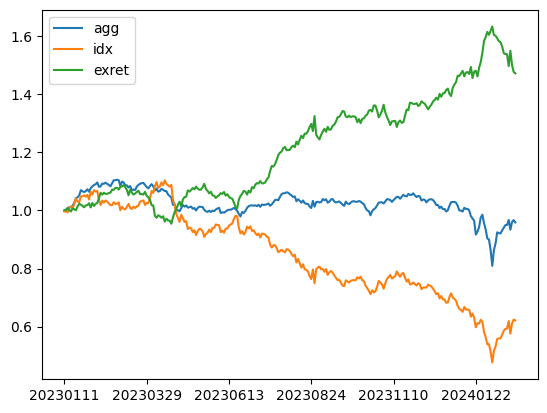

In [57]:
OPEN = pd.read_feather(os.path.join(ohlc_path, 'OPEN_PRICE_2.fea')).set_index('TRADE_DATE')
OPEN.index = pd.to_datetime(OPEN.index).strftime('%Y%m%d')
OPEN = OPEN.pct_change().shift(-1).replace([np.inf, -np.inf], np.nan)

#计算组合框架的收益和指数收益
dt_list = list(valid_stock_dict.keys())
agg_se = pd.Series(index=dt_list)
idx_se = pd.Series(index=dt_list)
for date in tqdm(dt_list):
    # with open(os.path.join(r'/home/datamake8/data0/底仓T0股票/stk_dict_update20240622',date+'.pkl'),'rb') as f:
    #     all_stock = pd.Series(pkl.load(f))
    all_stock = pd.Series(valid_stock_dict[date])
    all_stock.index = ['%06d'%x for x in all_stock.index]
    target_stock = all_stock[all_stock>0].copy()
    rq_stock = -all_stock[all_stock<0].copy()
    agg_ret = OPEN.loc[date].reindex(target_stock.index).fillna(0).mul(target_stock).sum()
    idx_ret = OPEN.loc[date].reindex(rq_stock.index).fillna(0).mul(rq_stock).sum()
    agg_se[date] = agg_ret
    idx_se[date] = idx_ret
total_df = pd.DataFrame({'agg':agg_se,'idx':idx_se})
total_df['exret'] = total_df['agg'] - total_df['idx']
(total_df+1).cumprod().plot()

In [ ]:
with open(r'/home/datamake8/data0/底仓T0股票/test20240619_allstk_long_0.01_update20240620.pkl','wb') as f:
    pkl.dump(valid_stock_dict,f)

100%|██████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 568.75it/s]


<Axes: >

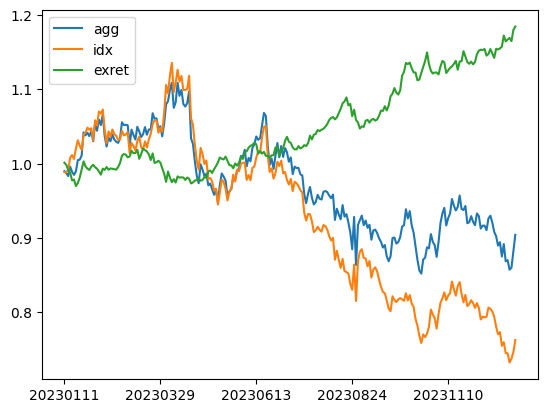

In [ ]:
OPEN = pd.read_feather(os.path.join(ohlc_path, 'OPEN_PRICE_2.fea')).set_index('TRADE_DATE')
OPEN.index = pd.to_datetime(OPEN.index).strftime('%Y%m%d')
OPEN = OPEN.pct_change().shift(-1).replace([np.inf, -np.inf], np.nan)

#计算组合框架的收益和指数收益
dt_list = list(valid_stock_dict.keys())
agg_se = pd.Series(index=dt_list)
idx_se = pd.Series(index=dt_list)
for date in tqdm(dt_list):
    if dt_list.index(date)%5==0:
        all_stock = pd.Series(valid_stock_dict[date])
        all_stock.index = ['%06d'%x for x in all_stock.index]
        target_stock = all_stock[all_stock>0].copy()
        rq_stock = -all_stock[all_stock<0].copy()
    agg_ret = OPEN.loc[date].reindex(target_stock.index).fillna(0).mul(target_stock).sum()
    idx_ret = OPEN.loc[date].reindex(rq_stock.index).fillna(0).mul(rq_stock).sum()
    agg_se[date] = agg_ret
    idx_se[date] = idx_ret
total_df = pd.DataFrame({'agg':agg_se,'idx':idx_se})
total_df['exret'] = total_df['agg'] - total_df['idx']
(total_df+1).cumprod().plot()

In [ ]:
valid_stock_dict['20230112']

{6: 0.0015,
 25: 0.0015,
 32: 0.0015,
 34: 0.0015,
 35: 0.0015,
 40: 0.0015,
 49: 0.0015,
 58: 0.0015,
 60: 0.0015,
 400: 0.0015,
 403: 0.0015,
 537: 0.0015,
 560: 0.0015,
 561: 0.0015,
 563: 0.0015,
 567: 0.0015,
 576: 0.0015,
 591: 0.0015,
 593: 0.0004348802009875776,
 597: 0.0015,
 603: 0.0015,
 610: 0.0009374258332409216,
 615: 0.0015,
 629: 0.0015,
 630: 0.0015,
 657: 0.0015,
 666: 0.0015,
 681: 0.0015,
 683: 0.0015,
 690: 0.0015,
 698: 0.0015,
 721: 0.0015,
 729: 0.0015,
 736: 0.00023330874760570108,
 737: 0.0015,
 739: 0.0015,
 762: 0.0015,
 807: 0.0015,
 815: 0.0015,
 818: 0.0015,
 848: 0.0015,
 860: 0.0015,
 887: 0.0015,
 909: 0.0015,
 913: 0.0015,
 915: 0.0015,
 921: 0.0015,
 923: 0.0015,
 935: 0.0015,
 951: 0.0015,
 961: 0.0015,
 970: 0.0015,
 975: 0.0015,
 998: 0.0015,
 999: 0.0015,
 1217: 0.0015,
 1258: 0.0015,
 1270: 0.0015,
 1301: 0.0015,
 1338: 0.0015,
 1914: 0.0015,
 2002: 0.0015,
 2006: 0.0015,
 2010: 0.0015,
 2011: 0.0015,
 2015: 0.0015,
 2020: 0.0015,
 2025: 0.0015,